# Using pjbcmassistant for Bayesian modeling

`pyjags` is a Python module that provides an interface to `JAGS`, a
Gibbs sampling application. `pjbcmassistant` offers two convenience classes to make it easier to use this module and analyze its results.

These were designed to perform the code exercises accompanying the book Bayesian Cognitive Modeling.

The following code demos require `JAGS`, `pyjags`, `pjbcmassistant`, and their dependencies.

#### importing modules

Before we can run a model, we must import the software that will handle it. The code below assumes that the file `pyjagsbcmassistant.py` is in the *parent* directory of the current notebook. If `pyjagsbcmassistant.py` is in the *same* directory, or in a directory listed in `sys.path`, you may simply write `from pjbcmassistant import ModelHandler, SampleHandler`

In [1]:
import pyjags

# this import assumes pjbcmassistant.py is ONE folder
# above this notebook. You may need to redirect it if
# you get a ModuleNotFoundError.
import os
nb_path = os.getcwd()
parent_path = os.path.split(nb_path)[0]
os.chdir(parent_path)
from pjbcmassistant import ModelHandler, SampleHandler
os.chdir(nb_path)

#### defining the model specifications

`ModelHandler` is set up using a settings file style string, intended to be easy to read and quick to edit. In it, we state the model and the various parameters that `JAGS` needs to perform sampling.

Below is an example model specification string. It can also be found by calling `print(ModelHandler.specification_template)`.

In [2]:
model_spec_string = """
model: #model code or local .txt file
model{
  for (i in 1:observationCount){ 
    testScores[i] ~ dnorm(mu, lambda)
  }
  mu ~ dunif(0,10)
  lambda ~ dgamma(.001,.001)
}

settings:
chains = 3 #number of chains to run
samples = 1000 #number of samples per chain
thinning = 0 #number of samples to discard between recorded samples
burnin = 500 #number of burn-in samples per chain

data:
testScores = [1,2,3,4,5,6,7,8] # can be integer or list
observationCount = len(testScores) # variables can be assigned using Python expressions

sample: #model variables to record, one per line
mu
lambda
"""

Note that we could also specify our model by pointing ModelHandler to a .txt file, such as `MyModel.txt`, so long as that .txt file is in the same directory as the notebook.

#### Creating the model & sample handlers.

The following steps are always exactly the same. If you're not interested in the details, you can always just copy and paste the code below.

Now that we have our *specification string*, we need to process it into a format `pyjags` will accept. This is done by

1. using ModelHandler to create an object representing the model specification. 
2. calling that object's method `.get_model_args()` to get the arguments and
3. passing them to`pyjags.Model`to create a `pyjags` model object
4. calling the method `.sample` on that `pyjags` model (using arguments passed via `.get_sample_args()`)
5. creating a sample handler object out of those samples, using `SampleHandler`.

Note: ModelHandler is only here to make simple models a little easier to read and edit. Its usage is totally optional -- see the `pyjags` documentation for defining model and sample arguments manually.

In [3]:
# 1. create our model specification object
model_specification = ModelHandler(model_spec_string)

# 2,3. pass our specification's model arguments to pyjags.Model
# to create a PyJAGS model object.
pyjags_model = pyjags.Model(**model_specification.get_model_args())

# 4. pass our specification's sample arguments to pyjags.sample
# to generate our samples (as an array).
sampled_data = pyjags_model.sample(**model_specification.get_sample_args())

# 5. create our sample handler object, to process the data we got.
sample_handler = SampleHandler(sampled_data)

adapting: iterations 1500 of 1500, elapsed 0:00:00, remaining 0:00:00
sampling: iterations 3000 of 3000, elapsed 0:00:00, remaining 0:00:00


### Using the sample handler

The sample handler has a number of methods we can call to help us analyze the results of our model.

#### Summary statistics:

In [4]:
sample_handler.summarize()

,mean,std dev,median,mode,HPD,95CI
lambda,0.167881,0.091028,0.152014,0.139792,"[0.02, 0.344]","[0.042, 0.394]"
mu,4.503919,1.051001,4.485745,4.416659,"[2.323, 6.571]","[2.409, 6.713]"


In [5]:
sample_handler.summarize_var("mu")

{'var': 'mu',
 'mean': 4.503918915232861,
 'median': 4.48574479245789,
 'std dev': 1.0510012335692211,
 '95CI': array([2.409, 6.713]),
 'HPD': array([2.323, 6.571]),
 'mode': 4.416659086986337}

In [6]:
sample_handler.get_statistic(variable="mu", statistic="mean")

4.503918915232861

#### Convergence tests:

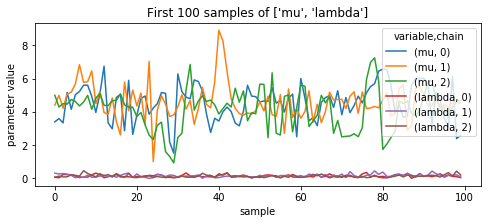

In [7]:
sample_handler.vizchains("mu","lambda")

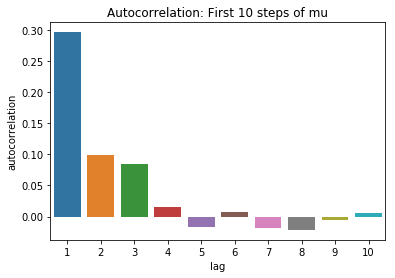

In [8]:
sample_handler.autocorr("mu")

In [9]:
sample_handler.diagnostic()

all PSRF values < 1.05 | maximum PSRF: mu at 0.9997487352293711.


In [10]:
sample_handler.psrf("mu")

0.9997487352293711

#### Visualization:

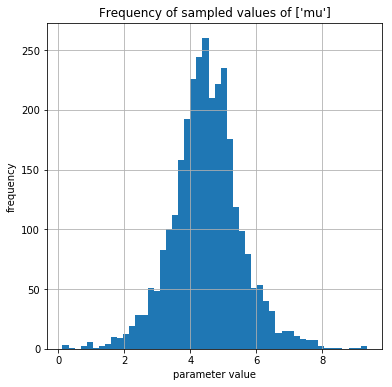

In [11]:
sample_handler.vizhist("mu")

/home/isaiah/anaconda3/envs/pyjagsBCM/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


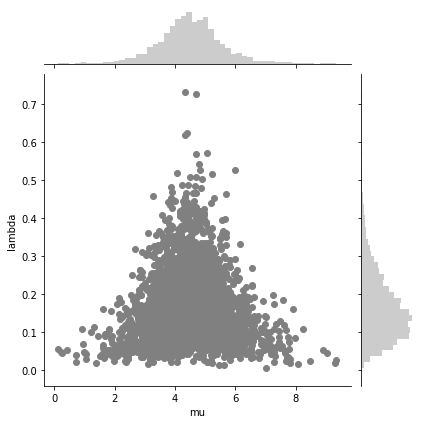

In [12]:
sample_handler.vizjoint("mu","lambda")

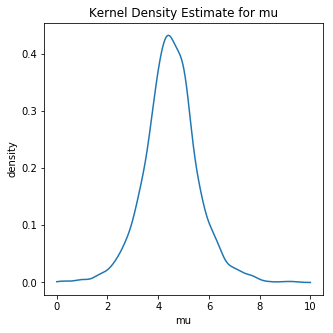

In [13]:
sample_handler.vizkde("mu", range=(0,10))

### More advanced usage

#### Advanced model specification

The data we want to pass our model will not always be easy to type inline.

We may wish to import it from an external file, or we may want to manipulate it before sending it to `pyjags`. In that case, we'll perform any desired operations in Python, before calling `ModelHandler.set_data` to pass it into our model handler.

Ultimately, all that matters is that `pyjags` gets a number or an array of numbers for any data variables the model is expecting.

In [14]:
# More complex data:
model_spec_string = """
model:
MyModel.txt #

settings:
chains = 3
samples = 1000
thinning = 0
burnin = 500

data:
# data will be passed in using ModelHandler.set_data method.

sample:
mu
lambda
"""



#load in data
with open("example_data.csv", "r") as example_data:
    #format data however needed
    data_array = [int(i.rstrip()) for i in example_data]

#derive model variables from the data
observationCount = len(data_array)


#create our model handler object
model_specification = ModelHandler(model_spec_string)

# pass the manipulated data to the model handler
model_specification.set_data("testScores", data_array)
model_specification.set_data("observationCount", observationCount)

# Code for sampling data.
pyjags_model = pyjags.Model(**model_specification.get_model_args())
sampled_data = pyjags_model.sample(**model_specification.get_sample_args())
sample_handler = SampleHandler(sampled_data)

adapting: iterations 1500 of 1500, elapsed 0:00:00, remaining 0:00:00
sampling: iterations 3000 of 3000, elapsed 0:00:00, remaining 0:00:00


Note: this time, we set our model by referencing a .txt file. We can make sure we gave it the correct file like so:

In [15]:
print(model_specification.model)

# Sample Model
model{
  for (i in 1:observationCount){ 
    testScores[i] ~ dnorm(mu, lambda)
  }
  mu ~ dunif(0,10)
  lambda ~ dgamma(.001,.001)
}



#### Missing and censored data

Censored/missing data must be set as NaN values. This can be done using `float('nan')` or `numpy.nan`.

Alternatively, data can be passed as a `numpy` array with the censored/missing values masked.

This will typically be easier to do using the `ModelHandler.set_data` method, rather than inside the model specification string.

#### Advanced data vizualization:

The `SampleHandler` doesn't provide every visualization you may want to perform. However, it  still provides access to all of the raw sample data, so you can use any Python plotting package you wish to display the data.

Here's a basic example, using `matplotlib`, where we'll plot every sample value, and overlay the data we passed the model across the center.

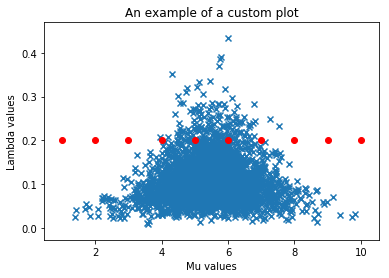

In [16]:
# Import the packages we'll need to do our visualization
import matplotlib.pyplot as plt
import numpy as np

# Access the samples via the SampleHandler's samples dictionary
x = sample_handler.samples['mu']
y = sample_handler.samples['lambda']

plt.xlabel('Mu values')
plt.ylabel('Lambda values')
plt.title('An example of a custom plot')
plt.scatter(x, y, marker='x')

# Access the input data via the ModelHandler' data dictionary
input_data = model_specification.data['testScores']
plt.scatter(input_data, [.2 for i in input_data], marker='o', color='r');
